# Tracking Rpb1 foci

I want to try to track Rpb1 foci to get a sense of their kinetics (specifically estimating pol2 loading rate and comparing it to the plausible rate of adding elongating pol2 molecules). The higher-order question is whether pol2 foci contain non-elongating pol2 molecules or whether we are just seeing elongation.

For tracking, I want to focus on very early cycle nuclei, where the Rpb1 foci are less numerous. As of right now, I just want to try tracking them to see if it's possible. It's also possible the imaging conditions will need to be re-worked, specifically the Z-sampling or time resolution. I imagine zooming in to subsets of nuclei is certainly going to be a part of this effort. Anyway, for now I'll try what I've got, and I can trade off analysis and experiments once I get going.

In [2]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage as ndi 
from importlib import reload
import skimage as ski
import pickle
import czifile

# The order of loading matplotlib is important to avoid issues on my machine.
%matplotlib inline
import matplotlib as mpl
#%matplotlib notebook
#%matplotlib notebook

# Import my packages.
import sys
sys.path.append('/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin')
import imagep as imp
reload(imp)
from imagep import viewer, save_pickle, load_pickle, box_spots, read_czi

## Which movies? 

I've already identified the useful existing movies that have early Rpb1 dynamics. I'll review these and see which to start with.

I think the two best are 20200729-rpb1-Hb-em1-zsmv-03.czi, which looks like one cycle earlier than 20200730-rpb1-Hb-em1-zsmv-04.czi

In [2]:
stack1 = read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/Dots_coming_on/20200729-rpb1-Hb-em1-zsmv-03.czi')
stack2 = read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/Dots_coming_on/20200730-rpb1-Hb-em1-zsmv-04.czi')

In [3]:
viewer(stack1)

interactive(children=(Dropdown(description='Color', index=7, options=('viridis', 'Reds', 'magma', 'cividis', '…

Probably start with some kind of filtering. DoG is a good way to find spots.

In [111]:
# Start with a test z stack.
z1 = stack1[0,11]
dog_f_13 = imp.dog_filter(f, [0,1,1],[0,3,3])
dog_f_13[dog_f_13 <= 0] = 0

In [112]:
viewer([dog_f_13, z1 * (np.max(dog_f_13) / np.max(z1))])

interactive(children=(Dropdown(description='Color', index=7, options=('viridis', 'Reds', 'magma', 'cividis', '…

The MS2 approach of fitting local maxes isn't gonna work. I think this is gonna require a thresholding, binarize, connect components, and then fit the resulting spots.

Unfortunately that means determining a threshold which is always awful.

In [113]:
viewer(dog_f_13)

interactive(children=(Dropdown(description='Color', index=7, options=('viridis', 'Reds', 'magma', 'cividis', '…

In [128]:
ski.filters.thresholding.threshold_multiotsu(dog_f_13, classes=3)

We will have to see if this is stable, but it seems like a reasonable thing for now.

In [200]:
?ski.filters.thresholding.threshold_sauvola

In [201]:
ski.filters.thresholding.threshold_niblack(dog_f_13)

135.39967278269532

In [131]:
t = ski.filters.thresholding.threshold_multiotsu(dog_f_13, classes=3)[1]

In [132]:
t

2612

In [162]:
viewer(labelmask)

interactive(children=(Dropdown(description='Color', index=7, options=('viridis', 'Reds', 'magma', 'cividis', '…

In [3]:
from fitting import fitgaussian3d, gaussian3d
from imagep import get_object_centroid, clamp

def fit_objects_from_mask(stack, mask, fitwindow_rad_xy=10, fitwindow_rad_z=2):  
    def get_fitwindow(data, peak, xy_rad, z_rad):
        """Retrieve section of image stack corresponding to given
        window around a point and the coordinate adjustments necessary
        to convert window coordinates to coordinates in the original image"""
        
        # Set the start points for windows and "adjust" them if they get 
        # to negative numbers.
        zmin = peak[0] - z_rad
        xmin = peak[1] - xy_rad
        ymin = peak[2] - xy_rad
        # Initialize adjustments to values that are correct if no edge problems 
        # are encountered.
        z_adj = -z_rad
        x_adj = -xy_rad
        y_adj = -xy_rad
        # Update mins and adjustments if windows start at negative coordinates.
        if (zmin < 0):
            zmin = 0
            z_adj = -peak[0]
        if (xmin < 0):
            xmin = 0
            x_adj = -peak[1]
        if (ymin < 0):
            ymin = 0
            y_adj = -peak[2]

        # Get end points, constained by max coordinate in data.
        zmax = min(data.shape[0] - 1, peak[0] + z_rad)
        xmax = min(data.shape[1] - 1, peak[1] + xy_rad)
        ymax = min(data.shape[2] - 1, peak[2] + xy_rad)

        return (data[zmin:(zmax+1), xmin:(xmax+1), ymin:(ymax+1)], z_adj, x_adj, y_adj)
    
    def get_centroids(labelmask):
        centroids = []
        for id_ in np.unique(labelmask):
            centroids.append(get_object_centroid(labelmask, id_))
        return centroids
    
    def fit_frame(substack, submask):
        labelmask = ndi.label(submask)[0]
        peaks = get_centroids(labelmask)
        
        # Fit 3D gaussian in window surrounding each local maximum.
        fitparams = np.ndarray((0,7))
        for peak in peaks:
            fitwindow, z_adj, x_adj, y_adj = get_fitwindow(substack, peak, fitwindow_rad_xy, 
                fitwindow_rad_z)
            opt = fitgaussian3d(fitwindow)
            if opt.success:
                peak_fitparams = opt.x
                # Move center coordinates to match center of gaussian fit, ensure they're within image. 
                # If they're outside the image, coordinate is assigned as the edge of the image.
                peak_fitparams[0] = int(round(clamp((peak[0] + peak_fitparams[0] + z_adj), 0, substack.shape[-3]-1)))
                peak_fitparams[1] = int(round(clamp((peak[1] + peak_fitparams[1] + x_adj), 0, substack.shape[-2]-1)))
                peak_fitparams[2] = int(round(clamp((peak[2] + peak_fitparams[2] + y_adj), 0, substack.shape[-1]-1)))
                fitparams = np.vstack((fitparams, peak_fitparams))
            # If fit fails, add dummy entry for spot.
            else:
                fitparams = np.vstack((fitparams, np.array([z_adj,x_adj,y_adj,0,np.inf,np.inf,np.inf])))
        return fitparams
    
    fit_data = []
    for t in range(0, stack.shape[0]):
        print(t)
        fit_data.append(fit_frame(stack[t], mask[t]))
    
    return fit_data

In [248]:
stack3 = read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/Dots_coming_on/20210305-Rpb1GFP-eveMS2-em2-zsmv-01.czi')
channel=0
sigma_big = 3
sigma_small = 1

stack = stack3[channel]
dog = imp.dog_filter(stack, [0,0,sigma_small,sigma_small],[0,0,sigma_big,sigma_big])
viewer(dog)

interactive(children=(Dropdown(description='Color', index=7, options=('viridis', 'Reds', 'magma', 'cividis', '…

In [250]:
viewer(stack3[0])

interactive(children=(Dropdown(description='Color', index=7, options=('viridis', 'Reds', 'magma', 'cividis', '…

In [251]:
t=2000
mask = np.where(dog >= t, 1, 0)

In [255]:
fits = fit_objects_from_labelmask(stack[0:2], mask[0:2], fitwindow_rad_z=1, fitwindow_rad_xy=3)

0
1


In [258]:
fits[1].shape

(120, 7)

OK, so the fitting is good. Now I need to connect spots betwixt frames. I should be able to repurpose code from MS2 spot tracking. One thing to potentially correct for is the movement of nuclei. I think this should be pretty easy to handle with some nuclear segmentation and centroid finding.

In [4]:
from imagep import labelmask_filter_objsize, relabel_labelmask

def segment_nuclei3D_simple(substack, sigma=3, size_min=0, size_max=np.inf):
    sm = ndi.gaussian_filter(substack, sigma)
    t = ski.filters.thresholding.threshold_otsu(sm)
    mask = np.where(sm >= t, 1, 0)
    labelmask, _ = ndi.label(mask)
    labelmask = labelmask_filter_objsize(labelmask, size_min, size_max)
    return labelmask

In [287]:
a = imp.segment_nuclei_4dstack(stack3[0], segment_nuclei3D_simple, size_min=1e4)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 


In [289]:
b = imp.connect_nuclei(a)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 


In [41]:
def fits_adjust_nucmovement(labelmask, fits):
    num_objects = len(np.unique(labelmask))
    num_frames = labelmask.shape[0]
    positions = np.empty((2, num_objects, num_frames))
    positions[:] = np.nan
    for f in range(0, num_frames):
        labels = np.unique(labelmask[f])
        for label in labels:
            centroid = get_object_centroid(labelmask[f], label)
            x,y = centroid[-2:]
            positions[0, label, f] = x
            positions[1, label, f] = y
    
    mean_changes = np.zeros((2, positions.shape[2]))
    for pos in range(0,2):
        for col in range(1, positions.shape[2]):
            changes = positions[pos,:,col] - positions[pos,:,0]
            mean = int(np.nanmean(changes))
            mean_changes[pos, col] = mean
    x_adjustments = mean_changes[0]
    y_adjustments = mean_changes[1]
    #return mean_changes
    
    fits_adj = []
    fits_adj.append(fits[0])
    for f in range(1, len(fits)):
        adj = fits[f].copy()            
        adj[:,1] = adj[:,1] - x_adjustments[f]
        adj[:,2] = adj[:,2] - y_adjustments[f]
        fits_adj.append(adj)
    return fits_adj, x_adjustments, y_adjustments

def revert_nucmovement_adjustments(spot_data, x_adjustments, y_adjustments):
    spot_data_r = {}
    for spot_id in spot_data.keys():
        arr = spot_data[spot_id].copy()
        for i in range(0, spot_data[spot_id].shape[0]):
            #3,4
            t = int(spot_data[spot_id][i,0])
            x_adjustment, y_adjustment = x_adjustments[t], y_adjustments[t]
            arr[i,3] = arr[i,3] + x_adjustment
            arr[i,4] = arr[i,4] + y_adjustment
        spot_data_r[spot_id] = arr
    return spot_data_r

In [28]:
x_adjustments[0]

0.0

In [6]:
from imagep import labelmask_filter_objsize, relabel_labelmask

def segment_nuclei3D_simple(substack, sigma=3, size_min=0, size_max=np.inf):
    sm = ndi.gaussian_filter(substack, sigma)
    t = ski.filters.thresholding.threshold_otsu(sm)
    mask = np.where(sm >= t, 1, 0)
    labelmask, _ = ndi.label(mask)
    labelmask = labelmask_filter_objsize(labelmask, size_min, size_max)
    return labelmask

In [120]:
# Find spots by thresholding and fit.
stack3 = read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/Dots_coming_on/20210305-Rpb1GFP-eveMS2-em2-zsmv-01.czi', trim=True)

channel=0
sigma_big = 3
sigma_small = 1

stack = stack3[channel]
dog = imp.dog_filter(stack, [0,0,sigma_small,sigma_small],[0,0,sigma_big,sigma_big])

t=2500
mask = np.where(dog >= t, 1, 0)

fits = fit_objects_from_mask(stack, mask, fitwindow_rad_z=1, fitwindow_rad_xy=3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


In [138]:
fits_f = imp.filter_ms2fits(fits, 6)

/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin/imagep.py:2192: RuntimeWarning: divide by zero encountered in log
  Spots detected in new frame are connected to spots in previous frames


In [139]:
# Get nuclear movements.
#nucmask_init = imp.segment_nuclei_4dstack(stack3[0], segment_nuclei3D_simple, size_min=1e4)
#nucmask = imp.connect_nuclei(nucmask_init)
#nucmask = relabel_labelmask(nucmask)
fits_adj, x_adjustments, y_adjustments = fits_adjust_nucmovement(nucmask, fits_f)

In [140]:
reload(imp)
spots_connected = imp.connect_ms2_frames(fits_adj, nucmask, scale_xy=85, scale_z=230, max_jump=850, max_frame_gap=0)
spots_connected = revert_nucmovement_adjustments(spots_connected, x_adjustments, y_adjustments)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 

In [141]:
min_len = 4

# Filter for trajectory length.
spot_data = imp.filter_spot_duration(spots_connected, min_len)

In [142]:
# Add integration from signal.
ij_rad = 3
z_rad = 0.1
ij_scale = 1
z_scale = 1
spotchannel=0

spot_data2 = imp.add_volume_mean(spot_data, stack3, spotchannel, ij_rad, z_rad, ij_scale, z_scale)

10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 

In [143]:
# Add integration from gaussian fit.
wlength_ij = 13
wlength_z = 3
reload(imp)
spot_data3 = imp.add_gaussian_integration(spot_data2, wlength_ij, wlength_z)

In [144]:
a = imp.movie.make_spot_table(spot_data3, nucmask, 9)

In [153]:
a.mean()

1       6079.732759
2       6518.936782
3       7426.181034
4       6273.871921
5       5227.241379
           ...     
169     6869.301724
170     6803.961394
171    18543.917241
172    18731.077586
173    20884.233333
Length: 173, dtype: float64

In [158]:
imp.quickview_ms2(stack3, spot_data3, spot_id=15, MAX=True, figsize=15)

interactive(children=(Dropdown(description='Color', index=8, options=('magma', 'viridis', 'gray', 'Greens', 'g…

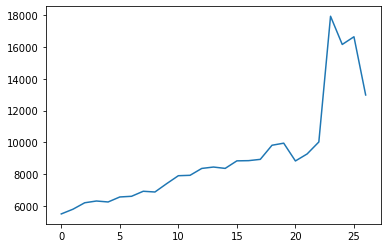

In [156]:
plt.plot(a.T.mean());

In [159]:
230*5

1150

In [161]:
230*8

1840

In [162]:
mv = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20180915-rpb1-eve-em4-zsmv-04-06.pkl')

In [178]:
ms2 = imp.spot_movies(mv.stack, mv.spot_data, len_ij=51, view=False, fill=0, channel=1)
prot = imp.spot_movies(mv.stack, mv.spot_data, len_ij=51, view=False, fill=0, channel=0)

In [188]:
a=ms2[:,:,2:5].max(axis=2)
b=ms2[:,:,2:5].mean(axis=2)
viewer([a, b * np.mean(a) / np.mean(b)], color='cividis',order='ctxy', figsize=6)

interactive(children=(Dropdown(description='Color', index=8, options=('magma', 'viridis', 'gray', 'Greens', 'g…

In [200]:
# Good spots: 11:
sigma=0.5
a_m = ndi.gaussian_filter(a, sigma=[0,0,sigma,sigma])
b_m = ndi.gaussian_filter(b, sigma=[0,0,sigma,sigma])
viewer([a_m, b_m * np.mean(a_m) / np.mean(b_m)], color='cividis',order='ctxy', figsize=6)


interactive(children=(Dropdown(description='Color', index=8, options=('magma', 'viridis', 'gray', 'Greens', 'g…

Can we classify spots by shape? 

OK what if I mask the spots and look at pol2 distributions within them?

In [220]:
b=ms2[:,:,2:5].mean(axis=2)
c=prot[:,:,2:5].mean(axis=2)
t = 1000
sigma=1
b_smooth = ndi.gaussian_filter(b, sigma=[0,0,sigma,sigma])
mask = np.where(b_smooth > t, 1, 0)
#Astruct = np.zeros(1,)
mask = ndi.morphology.binary_erosion(mask, structure=np.ones((1,1,2,2)))
mask = ndi.morphology.binary_dilation(mask, structure=np.ones((1,1,3,3)))
b_masked = np.where(mask, b, 0)
c_masked = np.where(mask, c, 0)
c_masked = c_masked * np.mean(b_masked) / np.mean(c_masked)
viewer([b_masked, c_masked], color='cividis', figsize=5)

interactive(children=(Dropdown(description='Color', index=8, options=('magma', 'viridis', 'gray', 'Greens', 'g…